In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/output/otto/

test_50.parquet		       train_20.parquet
test_50_tmp.parquet	       train_20_tmp.parquet
test_aid_features.parquet      train_50.parquet
test.parquet		       train_50_tmp.parquet
test_preds.csv		       train.parquet
test_session_features.parquet  valid_aid_features.parquet
train_20_old2.parquet	       valid_session_features.parquet
train_20_old.parquet


# Preprocessing

In [4]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

In [5]:
#test = pd.read_parquet('/content/drive/MyDrive/output/otto/test.parquet')
test = pd.read_parquet('/content/drive/MyDrive/output/otto/test_50_tmp.parquet')

In [6]:
def reduce_memory(df):
    df['session'] = df['session'].astype('int32')
    df['aid'] = df['aid'].astype('int32')
    df['score_click'] = df['score_click'].astype('float32')
    df['score_cart'] = df['score_cart'].astype('float32')
    df['score_buy'] = df['score_buy'].astype('float32')
    df['score_click_only'] = df['score_click_only'].astype('float32')
    df['score_cart_only'] = df['score_cart_only'].astype('float32')
    df['score_buy_only'] = df['score_buy_only'].astype('float32')
    df['session_action_count'] = df['session_action_count'].astype('int16')
    df['session_click_count'] = df['session_click_count'].astype('int16')
    df['session_cart_count'] = df['session_cart_count'].astype('int16')
    df['session_order_count'] = df['session_order_count'].astype('int16')
    df['session_type_mean'] = df['session_type_mean'].astype('float32')
    
    click_topn_list = [10, 20]
    for i in click_topn_list:
        df[f'n_clicks_{i}'] = df[f'n_clicks_{i}'].astype('int8')

    df['n_carts'] = df['n_carts'].astype('int8')
    df['n_buys'] = df['n_buys'].astype('int8')
    df['clicks_count'] = df['clicks_count'].astype('int32')
    df['carts_count'] = df['carts_count'].astype('int16')
    df['orders_count'] = df['orders_count'].astype('int16')
    return df

In [7]:
def join_aid_features(df):
    aid_df = pd.read_parquet('/content/drive/MyDrive/output/otto/test_aid_features.parquet')
    week_list = ['4weeks', '3weeks', '2weeks', '1week']
    aid_df['aid'] = aid_df['aid'].astype('int32')
    for i in week_list:
        aid_df[f'clicks_count_{i}'] = aid_df[f'clicks_count_{i}'].astype('int32')
        aid_df[f'carts_count_{i}'] = aid_df[f'carts_count_{i}'].astype('int16')
        aid_df[f'orders_count_{i}'] = aid_df[f'orders_count_{i}'].astype('int16')
        aid_df[f'clicks_rank_{i}'] = aid_df[f'clicks_rank_{i}'].astype('int32')
        aid_df[f'carts_rank_{i}'] = aid_df[f'carts_rank_{i}'].astype('int32')
        aid_df[f'orders_rank_{i}'] = aid_df[f'orders_rank_{i}'].astype('int32')
        for j in ['clicks', 'carts', 'orders']:
            for k in [2,3,4]:
                aid_df[f'aid_{j}_count_rate_1_{k}'] = aid_df[f'aid_{j}_count_rate_1_{k}'].astype('float32')


    remove_col = ['clicks_rank', 'carts_rank', 'orders_rank', 'clicks_count', 'carts_count', 'orders_count']
    #remove_col = ['clicks_rank_1week', 'carts_rank_1week', 'orders_rank_1week', 'clicks_count_1week', 'carts_count_1week', 'orders_count_1week']
    #df.drop(remove_col , axis=1)
    df = df.merge(aid_df, 'left', 'aid')
    #del session_df
    #gc.collect()
    
    return df

In [8]:
test = reduce_memory(test)

In [9]:
test.shape

(143574745, 23)

In [10]:
test = join_aid_features(test)

KeyboardInterrupt: ignored

In [ ]:
test

In [ ]:
DEBUG_MODE = False
#DEBUG_MODE = True

if DEBUG_MODE:
    test = test.head(100000)
IGNORE_COL = ['session','aid']

type_list = ['clicks', 'carts', 'orders']

#TYPE_MODE = 'clicks'
#TYPE_MODE = 'carts'
#TYPE_MODE = 'orders'

In [ ]:
n_splits = 5
session_splits = 5

In [ ]:
min_val = test['session'].min()
max_val = test['session'].max()
print('min session:', min_val, 'max_session:', max_val)

session_splits_list = [int(min_val) + int(i*(max_val - min_val) / session_splits) for i in range(session_splits)]
print('session_splits=', session_splits)
print('session_splits_list=', session_splits_list)

# Read Models

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

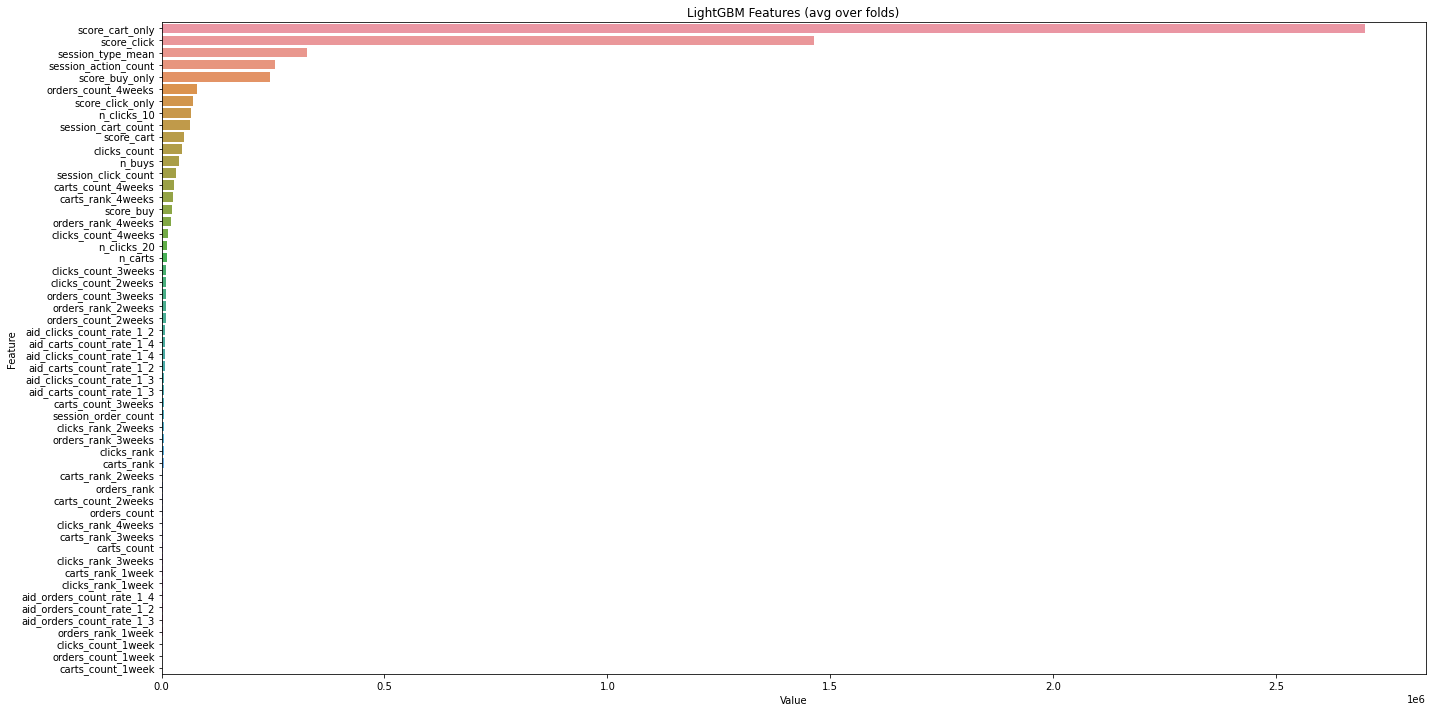

In [11]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)
model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_orders.pkl', allow_pickle=True)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

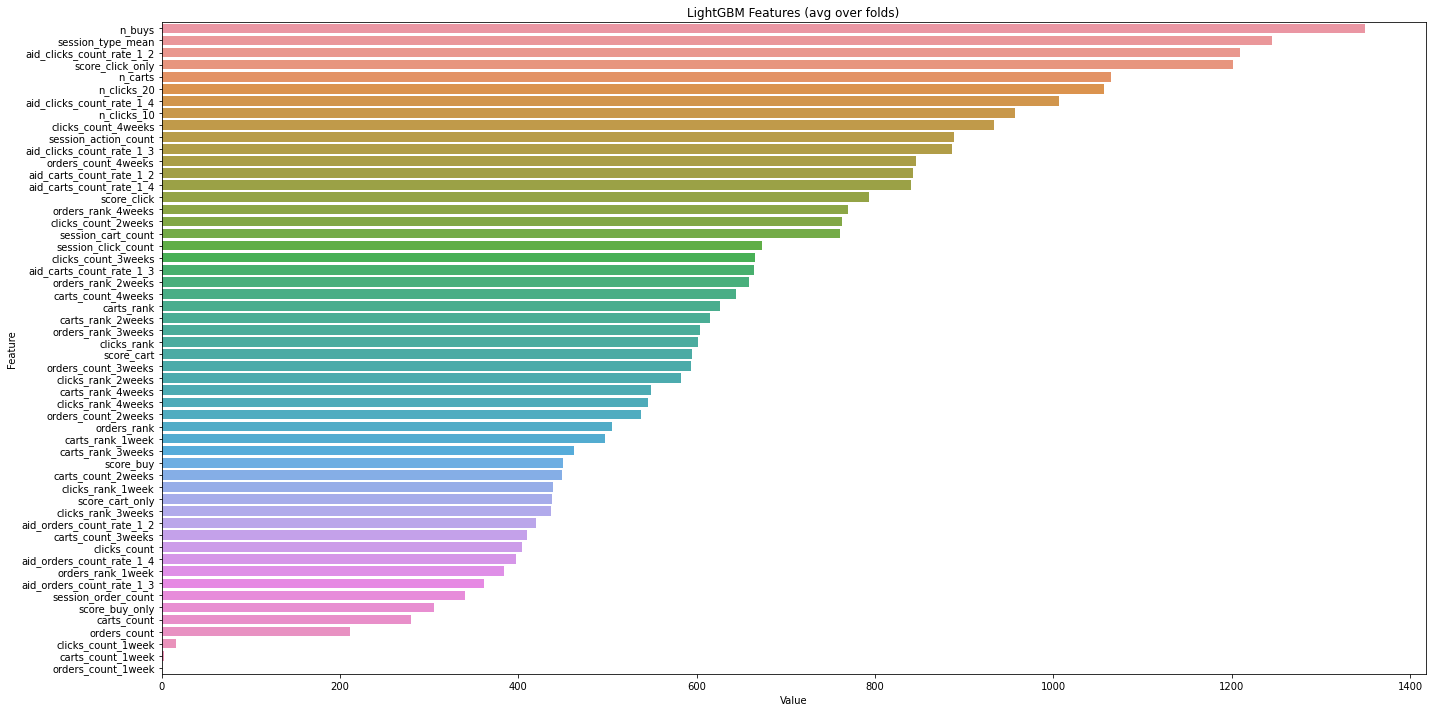

In [12]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
ans_list = []
# 分割してpredictするための準備
Nrow = test.shape[0]
Ndiv = 5
n = int(Nrow // Ndiv) + 1
x_test = test.drop(IGNORE_COL , axis=1)
x_test_list = []
for i in range(Ndiv):
    tmp = x_test.iloc[i*n : (i+1)*n, :]
    x_test_list.append(tmp)
del x_test
gc.collect()

for target in type_list:
    print('target=', target,'*************')
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))

    # fold looop 
    for fold in range(n_splits):
        print('fold=', fold)
        model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold{fold}_{target}.pkl', allow_pickle=True)

        test_pred_list = [] 
        for i, v in enumerate(x_test_list):
            print('test pred i=', i)
            tmp = model.predict(v)
            test_pred_list.append(tmp) 

        test_pred = np.concatenate(test_pred_list)
        del test_pred_list, model
        gc.collect()

        # testの場合はfoldの数で割る
        test_predictions += test_pred / n_splits

    ans_list.append(test_predictions)
    del test_predictions
    gc.collect()

del x_test_list
gc.collect()

target= clicks *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 1
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 2
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 3
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 4
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
target= carts *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 1
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 2
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 3
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 4
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
target= orders *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
f

0

In [ ]:
ans_list[0]

array([0.80119865, 0.18349396, 0.20332535, ..., 0.00182123, 0.00182363,
       0.00081607])

In [ ]:
sub_df_list = []

# 今後はこの2つのcolumnsしか使わないので削っておく
test = test[['session', 'aid']]

for i, t in enumerate(type_list):
    print(i, t)
    df = pd.DataFrame(ans_list[i], columns=["score"])
    pred_df = pd.concat([test, df], axis=1)
    #pred_df['aid'] = pred_df['aid'].astype('int32')
    del df
    gc.collect()
    for j in range(session_splits):
        print('splits session: ',j ,' from ' , session_splits_list[j])
        # last loop
        if j == session_splits - 1:
            tmp = pred_df[session_splits_list[j] <= pred_df['session']]
        else:
            tmp = pred_df[(session_splits_list[j] <= pred_df['session']) & (pred_df['session'] < session_splits_list[j+1])]
        tmp['session_type'] = tmp['session'].apply(lambda x: str(x) + f'_{t}')
        tmp = tmp.drop('session',axis=1)
        tmp = tmp.sort_values(['session_type','score'],ascending=[True, False]).reset_index(drop=True)
        tmp['n'] = tmp.groupby('session_type').cumcount().astype('int16')
        tmp = tmp.loc[tmp.n<20].drop(['n','score'],axis=1)
        tmp = tmp.groupby('session_type')['aid'].apply(list).reset_index()
        tmp['labels'] = tmp['aid'].map(lambda x: ''.join(str(x)[1:-1].split(',')))
        tmp = tmp.drop(['aid'],axis=1)
        sub_df_list.append(tmp)
        
    #pred_df['session_type'] = pred_df['session'].apply(lambda x: str(x) + f'_{t}')
    #pred_df = pred_df.drop('session',axis=1)
    #pred_df = pred_df.sort_values(['session_type','score'],ascending=[True, False]).reset_index(drop=True)
    #pred_df['n'] = pred_df.groupby('session_type').cumcount().astype('int16')
    #pred_df = pred_df.loc[pred_df.n<20].drop(['n','score'],axis=1)
    #print(pred_df.dtypes)
    #pred_df = pred_df.groupby('session_type')['aid'].apply(list).reset_index()
    #pred_df['labels'] = pred_df['aid'].map(lambda x: ''.join(str(x)[1:-1].split(',')))
    #pred_df = pred_df.drop(['aid'],axis=1)
    #sub_df_list.append(pred_df)
del tmp, test
gc.collect()

0 clicks
splits session:  0  from  12899779
splits session:  1  from  13317729
splits session:  2  from  13735680
splits session:  3  from  14153630
1 carts
splits session:  0  from  12899779
splits session:  1  from  13317729
splits session:  2  from  13735680
splits session:  3  from  14153630
2 orders
splits session:  0  from  12899779
splits session:  1  from  13317729
splits session:  2  from  13735680
splits session:  3  from  14153630


0

In [ ]:
#pred_df = pd.concat([sub_df_list[0], sub_df_list[1], sub_df_list[2]])
pred_df = pd.concat(sub_df_list)
del sub_df_list
gc.collect()

0

In [ ]:
pred_df.to_csv("/content/drive/MyDrive/output/otto/test_preds.csv", index=False)
pred_df.head()

,session_type,labels
0,12899779_clicks,59625 1253524 438191 737445 731692 94230 19942...
1,12899780_clicks,1142000 736515 582732 487136 973453 889686 136...
2,12899781_clicks,199008 1460571 918667 759436 811084 950718 754...
3,12899782_clicks,1007613 889671 479970 1033148 595994 834354 55...
4,12899783_clicks,1817895 607638 1492009 1754419 294573 300127 1...


In [ ]:
pred_df.shape

(5015409, 2)